### Notebook for analysing nf pipeline output

#### Sequencing batch 9

### Sequencing information 
 - Analysis no.: A004
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext FS
 - Seq Date: 18-05-2021
 - Number of samples:92

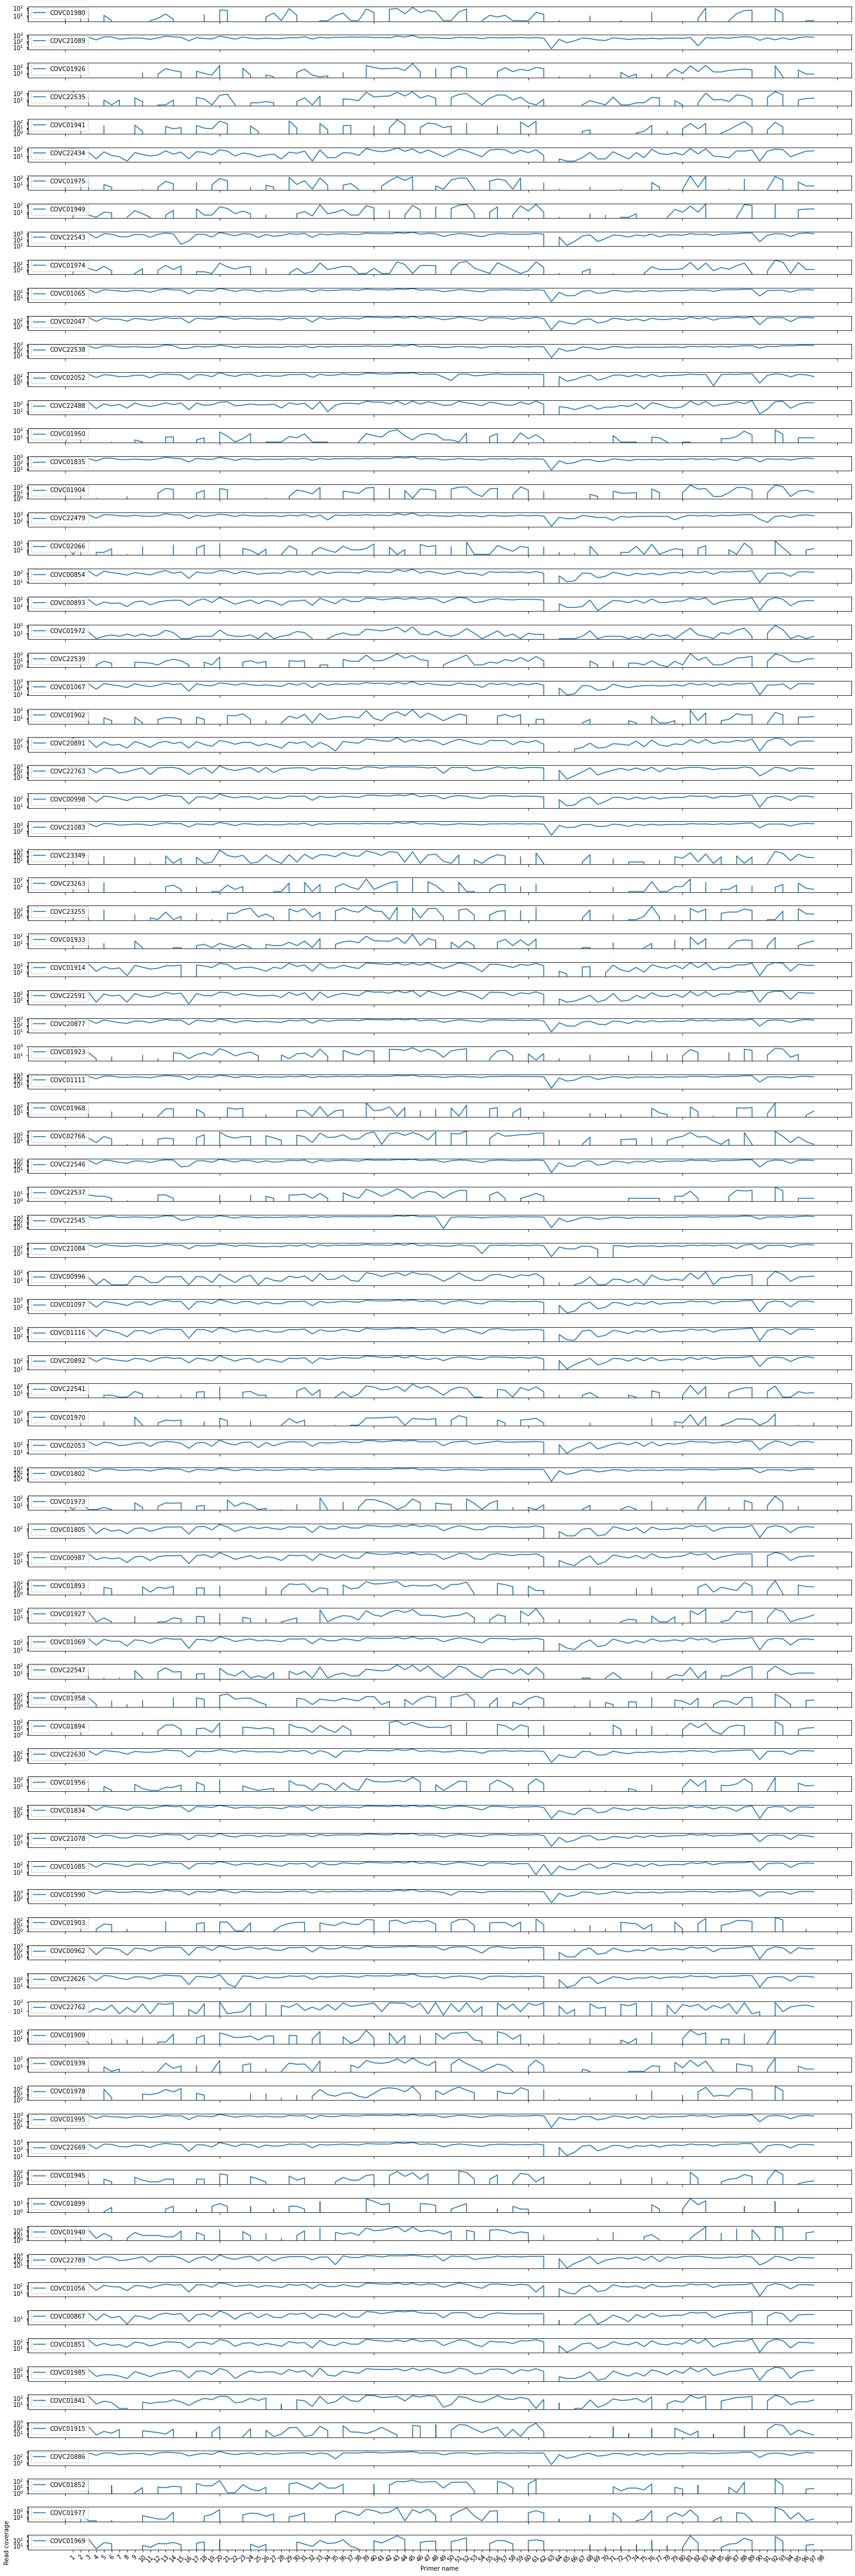

In [1]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/2021-05-18_run7/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,60)) 

xtick = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


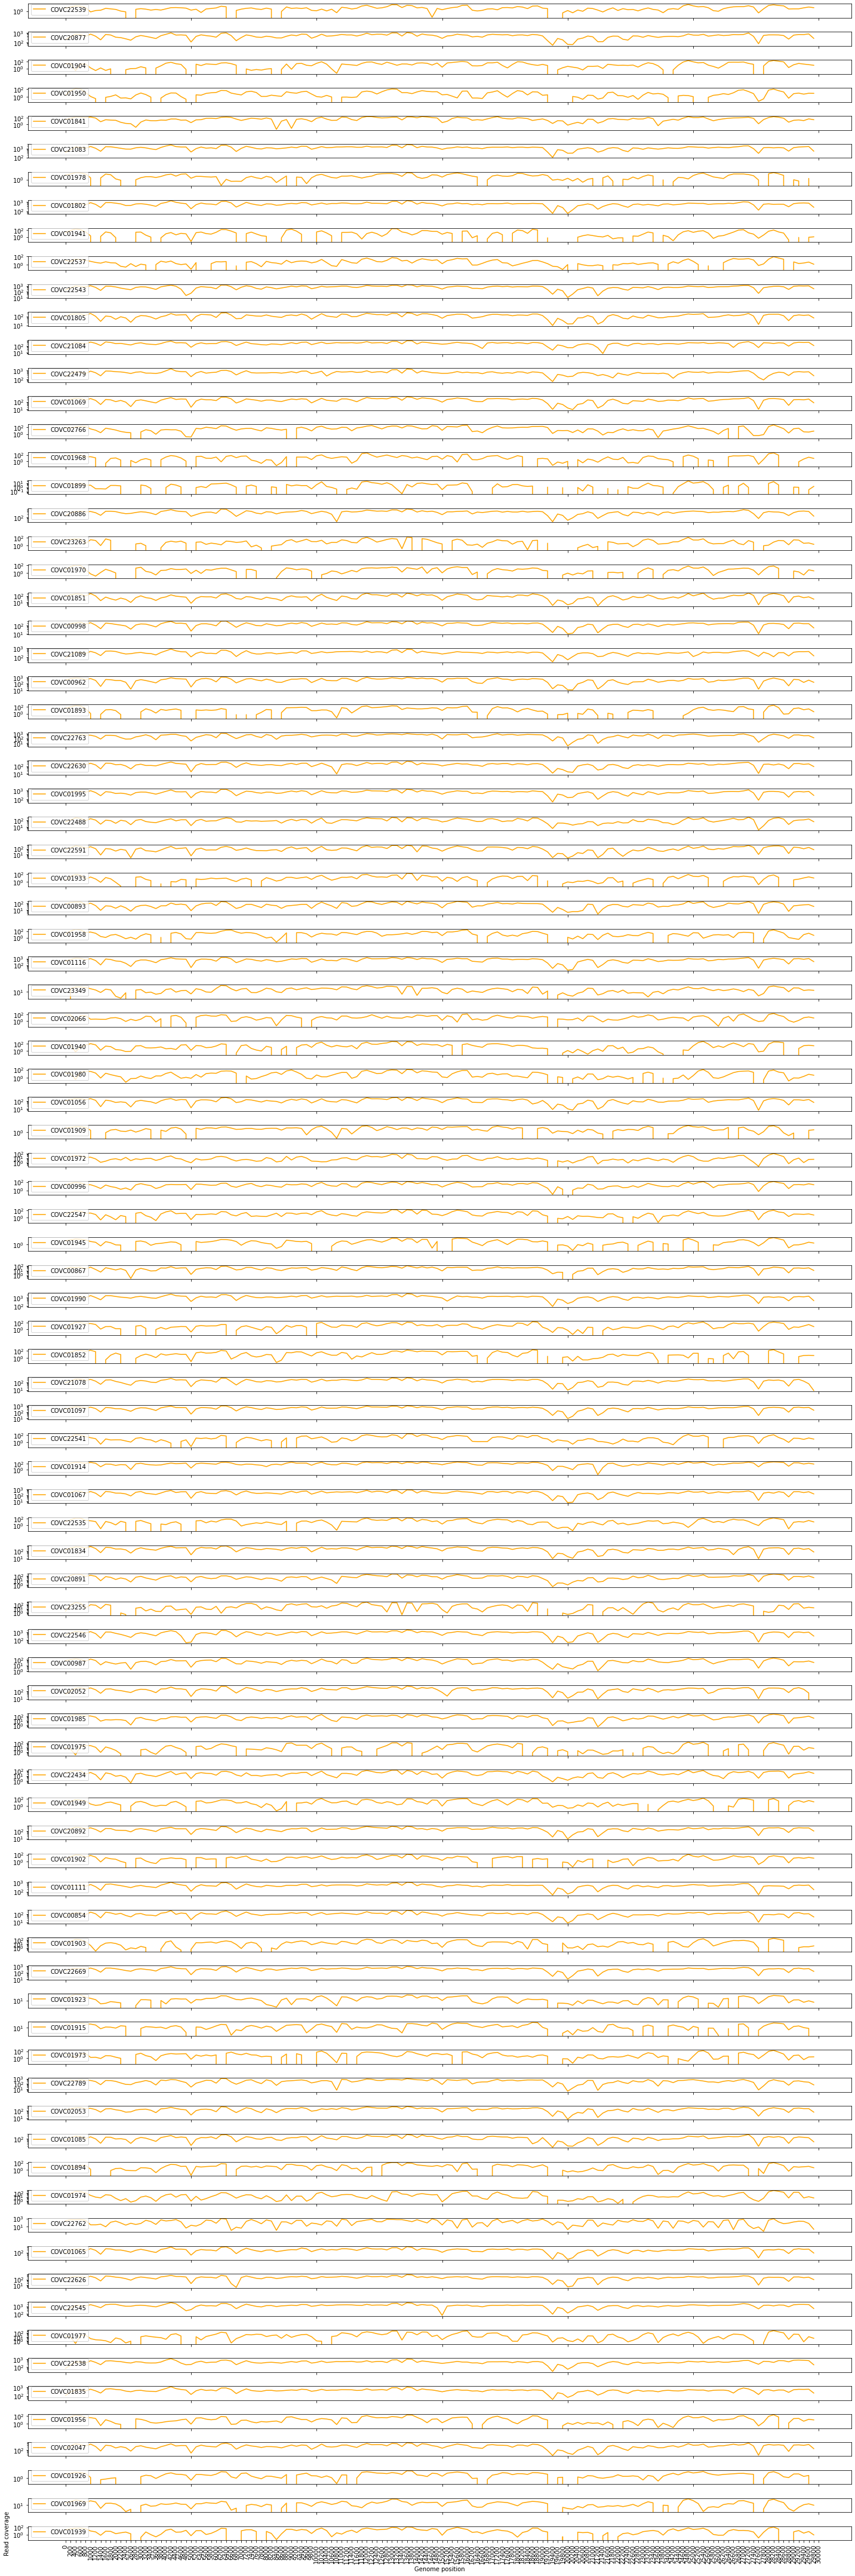

In [6]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
base_dir = '/home/douso/2021-05-18_run7/dpt'
suffix = '.genome.regions.coverage.tsv'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = range(0, 30200, 200)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
plt.xticks(xtick, rotation=90)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [2]:
base_dir = '/home/douso/2021-05-18_run7'
batch = 'seq9'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

### Sequencing information 
 - Analysis no.: NF-003 (batch 9)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext (FS)
 - Seq Date: MiSeq (18-05-2021)
 - Number of samples: 92
 - Sample summ: COVCs
 - VC pipeline: nextflow-viralcon

## Functions

In [3]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [4]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [5]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [6]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [7]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [8]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [10]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [11]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [12]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [13]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC01065,11,"T265I, F924F, K1233T, P1330P, L4715L, E5127E, ...",NaN,D614G,Q57H,NaN,NaN,NaN,W27L,NaN,NaN,NaN,R195K,NaN,NaN,NaN
1,COVC00962,8,"F924F, E961K, A3645A, L4715L",NaN,D614G,"D22_T24delinsA, V55F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,D341Y,NaN,NaN,NaN
2,COVC01902,7,"I201fs, T265I, T2936T, L4715L",NaN,NaN,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P13S,NaN,NaN,I13M
3,COVC20892,21,"E102Q, T265I, F924F, T2121I, T2684A, K3353R, A...",NaN,"D614G, L1200L, Q1201K","Q57H, Y113Y",NaN,NaN,NaN,NaN,NaN,NaN,"A14T, V62L","P13S, R195K, P207T",NaN,NaN,N25N
4,COVC22537,6,"M85del, E102Q, T3940T, I4334V",NaN,NaN,NaN,NaN,NaN,NaN,NaN,P34S,NaN,NaN,P13S,NaN,NaN,NaN


### Nextclade data

In [14]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/run9_con.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [15]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,COVC00854,20C,94.8
1,COVC00867,20C,66.7
2,COVC00893,20C,82.6
3,COVC00962,20A,93.3
4,COVC00987,20C,80.3


### Pangolin data v.2.4.2 (19-05-2021) Ran: 26-05-2021

In [57]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/run9.pangolin.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_cln1 = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months)))

In [58]:
df_png_fnl.head()

,Sequence_name,Lineage,Date_range,Most_common_countries
0,COVC00854,B.1,"Jan-24, Apr-13","USA, UK, Spain"
1,COVC00893,B.1.446,"Mar-13, Jul-02","USA, UK"
2,COVC00962,B.1,"Jan-24, Apr-13","USA, UK, Spain"
3,COVC00987,B.1.446,"Mar-13, Jul-02","USA, UK"
4,COVC00998,B.1,"Jan-24, Apr-13","USA, UK, Spain"


# Metadata

In [59]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results/ResultsMerged'
df_rmd_cln = pd.read_excel(f'{mbase_dir}/COVID19-results-merged.xlsx')

In [19]:
df_rmd_cln.head()

,S_NUM,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC22771,58,Years,M,HCW,Kenya,Nairobi,LAVINGTON,No,NaN,NaN,NaN,2021-01-01 00:00:00,2021-01-01 00:00:00,Negative,2021-01-01 00:00:00
1,COVC22772,63,Years,M,CEC,Kenya,Kiambu,THIKA,No,NaN,NaN,FLU,2020-12-31 00:00:00,2021-01-01 00:00:00,Negative,2021-01-01 00:00:00
2,COVC22773,53,Years,F,Psychologist,Kenya,Kiambu,THIKA,No,NaN,NaN,NaN,2021-01-01 00:00:00,2021-01-01 00:00:00,Negative,2021-01-01 00:00:00
3,COVC22774,52,Years,F,Business,Kenya,Kiambu,THIKA,No,NaN,NaN,CO;DIB,2021-01-02 00:00:00,2021-01-01 00:00:00,Negative,2021-01-01 00:00:00
4,COVC22775,41,Years,F,HCW,Kenya,Kiambu,GATUNDU NORTH,No,NaN,NaN,CO;DIB,2021-01-03 00:00:00,2021-01-01 00:00:00,Positive,2021-01-01 00:00:00


### Ct data

In [20]:
# import Ct data from sheet2 of the metadata file
ctbase_dir = '/home/douso/Documents/RunSheets/Cts'
df_cts = pd.read_excel(f'{ctbase_dir}/cov-allCts-merged.xlsx')

In [21]:
df_cts.head()

,Sample_Name,Average_Ct
0,COVC1849,16.3
1,COVC4504,17.4
2,COVC5267,20.3
3,COVC7585,23.9
4,COVC22135_1,25.6


### Combining data

#### Merge Variants and Nextclade data

In [22]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [23]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC00854,10,"T265I, F924F, L4715L, E4945G, T6177T",NaN,"D614G,","S26P, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,94.8
1,COVC00867,10,"T265I, F924F, L4715L, T6177T",NaN,"D614G, M900fs, M900fs","S26P, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,F3S,NaN,NaN,NaN,NaN,20C,66.7
2,COVC00893,10,"T265I, F924F, T2936T, L4715L, R6232Q",NaN,D614G,"S26P, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,F3S,NaN,NaN,NaN,I13M,20C,82.6
3,COVC00915,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COVC00962,8,"F924F, E961K, A3645A, L4715L",NaN,D614G,"D22_T24delinsA, V55F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,D341Y,NaN,NaN,NaN,20A,93.3


#### Merge pango and var-nextclade data

In [60]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [61]:
df_pngVxt.head()

,Sequence_name,Lineage,Date_range,Most_common_countries,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC00854,B.1,"Jan-24, Apr-13","USA, UK, Spain",10.0,"T265I, F924F, L4715L, E4945G, T6177T",NaN,"D614G,","S26P, Q57H",NaN,...,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,94.8
1,COVC00867,NaN,NaN,NaN,10.0,"T265I, F924F, L4715L, T6177T",NaN,"D614G, M900fs, M900fs","S26P, Q57H",NaN,...,NaN,NaN,NaN,F3S,NaN,NaN,NaN,NaN,20C,66.7
2,COVC00893,B.1.446,"Mar-13, Jul-02","USA, UK",10.0,"T265I, F924F, T2936T, L4715L, R6232Q",NaN,D614G,"S26P, Q57H",NaN,...,NaN,NaN,NaN,F3S,NaN,NaN,NaN,I13M,20C,82.6
3,COVC00915,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COVC00962,B.1,"Jan-24, Apr-13","USA, UK, Spain",8.0,"F924F, E961K, A3645A, L4715L",NaN,D614G,"D22_T24delinsA, V55F",NaN,...,NaN,NaN,NaN,NaN,D341Y,NaN,NaN,NaN,20A,93.3


In [62]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Date_range', 'Most_common_countries',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'DT_RANG', 'M_COMM_C',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [27]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Average_Ct': 'AVG_Ct'})

In [28]:
df_rmdCts.head()

,S_NUM,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,AVG_Ct
0,COVC0 708,35,NaN,F,Nil,Kenyan,Laikipia,Laikipia East,N,NaN,Nanyuki Teaching and Referral Hospital,Asymtomatic,9th June 2020,"June 11, 2020",Neg,2020-06-12 00:00:00,NaN
1,COVC0 709,32,NaN,F,Nil,Kenyan,Laikipia,Laikipia East,N,NaN,Nanyuki Teaching and Referral Hospital,Asymtomatic,9th June 2020,"June 11, 2020",Neg,2020-06-12 00:00:00,NaN
2,COVC0 710,45,NaN,M,Nil,Kenyan,Laikipia,Laikipia East,N,NaN,Nanyuki Teaching and Referral Hospital,Asymtomatic,9th June 2020,"June 11, 2020",Neg,2020-06-12 00:00:00,NaN
3,COVC0 711,Nil,NaN,M,Nil,Kenyan,Laikipia,Laikipia East,N,NaN,Nil,Asymtomatic,10th June 2020,"June 11, 2020",Neg,2020-06-12 00:00:00,NaN
4,COVC0 712,27,NaN,F,Nil,Kenyan,Laikipia,Laikipia East,N,NaN,Nil,Asymtomatic,10th June 2020,"June 11, 2020",Neg,2020-06-12 00:00:00,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [63]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [30]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'DT_RANG', 'M_COMM_C', 'N_VAR', 'ORF1ab', 'ORF1a', 'S',
       'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N',
       'ORF9a', 'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE', 'AGE_UNIT', 'GEND',
       'OCCU', 'NAT', 'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM',
       'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT',
       'DT_CONF', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [31]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'COVC00893', 'COVC00854', 'COVC00915', 'COVC00867'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [32]:
header_MS = ['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'M_COMM_C', 'DT_RANG', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [33]:
header_policy = ['S_NUM', 'AGE', 'AGE_UNIT', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [64]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
# (df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
# .to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M004.xlsx'
#                      , index=False, na_rep='N/A', float_format='%.1f'))

In [65]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
# (df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
# .to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS004.xlsx'
#                      , index=False, na_rep='NA', float_format='%.1f'))
df_vnpPmd_fnl.head()

,S_NUM,AGE,AGE_UNIT,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC00854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN
1,COVC00867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F3S,NaN,NaN,NaN,NaN
2,COVC00893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,F3S,NaN,NaN,NaN,I13M
3,COVC00915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COVC00962,31,NaN,M,Food handler,Kenyan,Nairobi,N,NaN,Nil,...,NaN,NaN,NaN,NaN,NaN,NaN,D341Y,NaN,NaN,NaN


### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617): *Indian variant

In [66]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [67]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVC02066,A570D,"A570D, S591S, D614G"


### Subsample brief data

In [68]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [69]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 80]

In [70]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,COUNT_RES,GEND,NAT
0,COVC00854,94.8,NaN,NaN,B.1,20C,NaN,NaN,NaN
2,COVC00893,82.6,NaN,NaN,B.1.446,20C,NaN,NaN,NaN
4,COVC00962,93.3,2020-06-08 00:00:00,"June 14, 2020",B.1,20A,Nairobi,M,Kenyan
5,COVC00987,80.3,2020-06-08 00:00:00,June 14 2020,B.1.446,20C,Nairobi,M,Kenyan
7,COVC00998,94.4,2020-06-08 00:00:00,"June 14, 2020",B.1,20C,Nairobi,M,Kenyan


#### Merge df_brief with df_moc

In [71]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [72]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [73]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC00854,94.8,N/A,N/A,B.1,20C,N/A,N/A,N/A,N/A
1,COVC00893,82.6,N/A,N/A,B.1.446,20C,N/A,N/A,N/A,N/A
2,COVC00962,93.3,2020-06-08 00:00:00,"June 14, 2020",B.1,20A,Nairobi,M,Kenyan,N/A
3,COVC00987,80.3,2020-06-08 00:00:00,June 14 2020,B.1.446,20C,Nairobi,M,Kenyan,N/A
4,COVC00998,94.4,2020-06-08 00:00:00,"June 14, 2020",B.1,20C,Nairobi,M,Kenyan,N/A


In [43]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        x = x.strftime(format='%d-%m-%Y')
    return x
    

In [74]:
import numpy as np
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: np.nan if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='ignore'))))

In [75]:
df_brfMoc_fnl

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC00854,94.8,N/A,N/A,B.1,20C,N/A,N/A,N/A,N/A
1,COVC00893,82.6,N/A,N/A,B.1.446,20C,N/A,N/A,N/A,N/A
2,COVC00962,93.3,08-06-2020,"June 14, 2020",B.1,20A,Nairobi,M,Kenyan,N/A
3,COVC00987,80.3,08-06-2020,June 14 2020,B.1.446,20C,Nairobi,M,Kenyan,N/A
4,COVC00998,94.4,08-06-2020,"June 14, 2020",B.1,20C,Nairobi,M,Kenyan,N/A
5,COVC01056,91.8,NaN,2020-06-15 00:00:00,B.1,20C,Nil,M,Kenyan,N/A
6,COVC01065,96.7,NaN,2020-06-15 00:00:00,B.1,20C,Nairobi,M,Kenyan,N/A
7,COVC01067,94.7,NaN,2020-06-15 00:00:00,B.1,20C,Nairobi,M,Kenyan,N/A
8,COVC01069,94.2,NaN,2020-06-15 00:00:00,B.1,20C,Kajiado,M,Kenyan,N/A
9,COVC01085,94.6,08-06-2020,2020-06-15 00:00:00,B.1,20C,Nairobi,F,Kenyan,N/A


In [76]:
df_report_fnl = df_brfMoc_fnl

In [77]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC00854,94.8,N/A,N/A,B.1,20C,N/A,N/A,N/A,N/A
1,COVC00893,82.6,N/A,N/A,B.1.446,20C,N/A,N/A,N/A,N/A
2,COVC00962,93.3,08-06-2020,"June 14, 2020",B.1,20A,Nairobi,M,Kenyan,N/A
3,COVC00987,80.3,08-06-2020,June 14 2020,B.1.446,20C,Nairobi,M,Kenyan,N/A
4,COVC00998,94.4,08-06-2020,"June 14, 2020",B.1,20C,Nairobi,M,Kenyan,N/A


In [88]:
# df_report_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T004-II.xlsx'
#                      , index=False, na_rep='N/A', float_format='%.1f')

In [ ]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [87]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
42,COVC22789,94.0,04-01-2021,2021-01-05 00:00:00,B.1,20A,Kiambu,M,Kenya,N/A
31,COVC22479,99.0,07-12-2020,2020-12-09 00:00:00,A.23,19B,Kiambu,M,Kenya,N/A
32,COVC22488,91.3,07-12-2020,2020-12-09 00:00:00,A.23,19B,Kiambu,F,Kenya,N/A
11,COVC01111,99.1,08-06-2020,2020-06-15 00:00:00,B.1,20C,Nairobi,M,Kenyan,N/A
10,COVC01097,96.6,08-06-2020,2020-06-15 00:00:00,B.1,20C,Nairobi,M,Kenyan,N/A
12,COVC01116,96.7,08-06-2020,2020-06-15 00:00:00,B.1,20C,Nairobi,M,Kenyan,N/A
4,COVC00998,94.4,08-06-2020,"June 14, 2020",B.1,20C,Nairobi,M,Kenyan,N/A
3,COVC00987,80.3,08-06-2020,June 14 2020,B.1.446,20C,Nairobi,M,Kenyan,N/A
2,COVC00962,93.3,08-06-2020,"June 14, 2020",B.1,20A,Nairobi,M,Kenyan,N/A
9,COVC01085,94.6,08-06-2020,2020-06-15 00:00:00,B.1,20C,Nairobi,F,Kenyan,N/A


In [80]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Kiambu      16
Nairobi      9
Kajiado      8
Nairobi      6
N/A          2
Nil          1
Kajiado      1
Name: Sample County of Origin, dtype: int64

In [85]:
clr_code = {'B.1.1.7': ('orange', '#FFA500'),
            'B.1.525': ('green', '#008000'),
            'B.1.351': ('blue', '#0000FF'),
            'B.1.549': ('brown', '#A52A2A'),
            'A.23.1': ('gray', '#808080'),
            'B.1.596.1': ('magenta', '#FF00FF'),
            'B.1': ('cyan', '#00FFFF'),
            'B.1.530': ('red', '#FF0000'),
            'A.23': ('lime', '#00FF00'),
            'B.1.143': ('olive', '#808000'),
            'B.1.1.171': ('teal', '#008080'),
            'B.1.343': ('indigo', '#4B0082'),
            'B.1.388': ('sienna', '#A0522D'),
            'B.1.1': ('chocolate', '#D2691E'),
            'B.1.605': ('rosybrown', '#BC8F8F'),
            'B.1.1.406': ('slategray', '#708090'),
            'B.1.446': ('palevioletred', '#DB7093'),
            'B.1.349': ('mediumpurple', '#9370DB'),
            'TBA8': ('tan', '#D2B48C'),
            'TBA9': ('aquamarine', '#7FFFD4')}

In [106]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [107]:
grpby_lins

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Next Clade Lineage Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
Pango Lineage Annotation,,,,,,,,,
B.1,29,29,25,29,29,29,29,29,29
B.1.1,3,3,3,3,3,3,3,3,3
B.1.446,3,3,3,3,3,3,3,3,3
A.23,2,2,2,2,2,2,2,2,2
B.1.530,2,2,2,2,2,2,2,2,2
B.1.1.406,1,1,1,1,1,1,1,1,1
B.1.349,1,1,1,1,1,1,1,1,1
B.1.549,1,1,1,1,1,1,1,1,1
B.1.605,1,1,1,1,1,1,1,1,1


In [108]:
lins = list(grpby_lins.index)

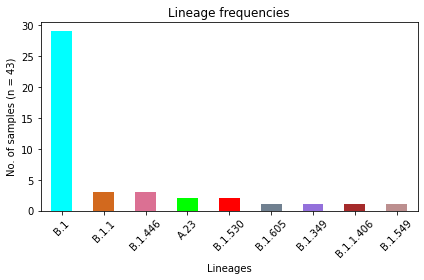

In [111]:
# plot lineage frequencies
colors = [clr_code[lin][1] for lin in lins]
n = df_report_fnl['Pango Lineage Annotation'].count()
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P004-II.png', dpi=300.0)
plt.show()